<div class="alert alert-block alert-info">
<b>Deadline:</b> January 21, 2026 (Wednesday) 23:59
</div>

# Exercise 2. Train a multilayer perceptron (MLP) with pytorch.

The goal of this exercise is to get familiar with the basics of PyTorch and train a multilayer perceptron (MLP) model.

If you are not familiar with PyTorch, please read the introductory material [here](https://pytorch.org/tutorials/beginner/basics/intro.html). We also recommend reading tutorials starting from [this page](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

In [37]:
skip_training = True  # Set this flag to True before validation and submission

In [1]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

ModuleNotFoundError: No module named 'einops'

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Select device which you are going to use for training
#device = torch.device("cuda:0")
device = torch.device("cpu")

In [5]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will train the MLP on a toy regression problem.

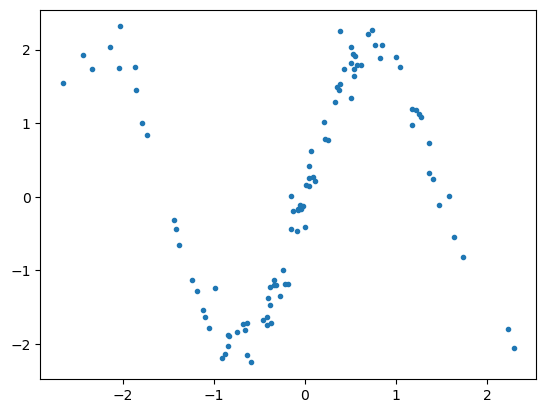

In [26]:
# Generate toy data
def get_data():
    np.random.seed(2)
    x = np.random.randn(100, 1)
    x = np.sort(x, axis=0)

    targets = 2 * np.sin(x * 2 * np.pi / 3)
    targets = targets + 0.2 * np.random.randn(*targets.shape)

    # Convert to PyTorch tensors
    x = torch.FloatTensor(x)
    targets = torch.FloatTensor(targets)

    return x, targets

x, targets = get_data()
# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')

# Multilayer perceptron (MLP) network with two hidden layers

We will create a simple multilayer perceptron (MLP) network. The model has
- input dimensionality 1
- one hidden layer with 10 units with Tanh nonlinearity
- one hidden layer with 11 units with Tanh nonlinearity
- linear output layer with output dimensionality 1 and no nonlinearity.

Hints:
* You may want to look at [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) for reference.
* You can use [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
module to define the fully-connected layers of the MLP.
* Simple architectures are usually created using module [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential). You do not have to use this module in this exercise.

In [27]:
class MLP(nn.Module):
    def __init__(self, n_inputs=1):
        super(MLP, self).__init__()
        self.fc1=nn.Linear(n_inputs,10)
        self.fc2=nn.Linear(10,11)
        self.fc3=nn.Linear(11,1)


    def forward(self, x):
        """
        Args:
          x of shape (n_samples, n_inputs): Model inputs.

        Returns:
          y of shape (n_samples, 1): Model outputs.
        """
        act1=F.tanh(self.fc1(x))
        act2=F.tanh(self.fc2(act1))
        y=self.fc3(act2)
        return y
    

In [28]:
# Let us create the network and make sure it can process a random input of the right shape
def test_MLP_shapes():
    n_inputs = 1
    n_samples = 10
    net = MLP()
    y = net(torch.randn(n_samples, n_inputs))
    assert y.shape == torch.Size([n_samples, 1]), f"Bad y.shape={y.shape}"
    print('Success')

test_MLP_shapes()

Success


## Train the MLP network

### Training loop

Your task is to implement the training loop.
You may find it useful to look at [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).
Your should have the following steps:
* Set all gradient values to zeros.
* Calculate the output of the model for all training examples.
* Calculate the MSE loss (see [mse_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html#torch.nn.functional.mse_loss)).
* Backpropagate the gradients: compute the gradients of the loss wrt to all the parameters of the model.
* Update the parameters of the model using the chosen optimizer.


Recommended hyperparameters:
* [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) with learning rate 0.01.
* You can process the data in the full-batch model (computing the gradients using all training data).
* Number of iterations (parameter updates): 200.

Notes:
* The loss for a well-trained model should be below 0.1. 

In [29]:
# Create the model
model = MLP()
model.to(device)

MLP(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=11, bias=True)
  (fc3): Linear(in_features=11, out_features=1, bias=True)
)

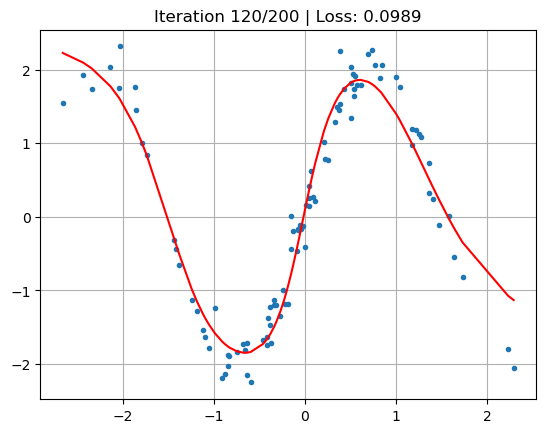

In [30]:

from IPython import display

if not skip_training:
    n_epochs = 200
    lr = 0.1 
    funct_loss = nn.MSELoss()
    
    n = 0
    # Initial forward pass to start the loop logic
    output = model(x)
    loss = funct_loss(output, targets)
    
    # Use loss.item() to get the numerical value for the comparison
    while loss.item() > 0.1 and n < n_epochs:
        # 1. Zero the gradients
        model.zero_grad()
        
        # 2. Re-run Forward Pass (Crucial: use 'x', not 'output')
        output = model(x)
        
        # 3. Calculate Loss
        loss = funct_loss(output, targets)
        
        # 4. Backward Pass (Calculates gradients)
        loss.backward()
        
        # 5. Gradient Descent Update
        with torch.no_grad(): # Use this context to modify weights
            for f in model.parameters():
                # Note: ensure 'learning_rate' variable name matches 'lr'
                f.sub_(f.grad * lr)
        
        n += 1
        
        # --- Visualization ---
        ax.clear()
        # Convert tensors to numpy for plotting
        ax.plot(x.detach().numpy(), targets.detach().numpy(), '.')
        ax.plot(x.detach().numpy(), output.detach().numpy(), 'r-')
        ax.grid(True)
        ax.set_title(f'Iteration {n}/{n_epochs} | Loss: {loss.item():.4f}')
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.005)

    display.clear_output(wait=True)

In [31]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(model, '2_mlp.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to 2_mlp.pth.


In [32]:
if skip_training:
    model = MLP()
    tools.load_model(model, '2_mlp.pth', device)

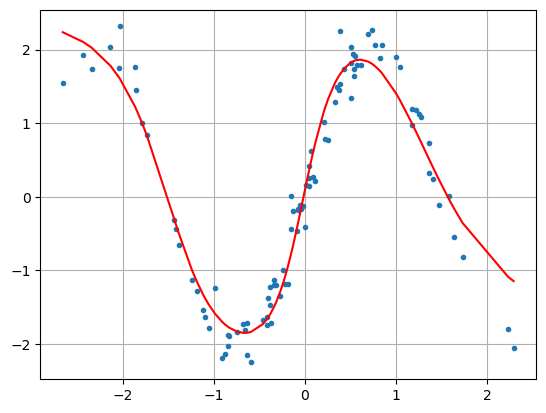

In [33]:
# Plot the trained MLP
with torch.no_grad():
    fig, ax = plt.subplots(1)
    ax.plot(x, targets, '.')
    y = model(x)
    ax.plot(x, y.numpy(), 'r-')
    ax.grid(True)

In [34]:
# This cell tests MLP

In [35]:
# This cell tests MLP

In [36]:
# This cell is used for grading

<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

Now you have trained an MLP network using PyTorch. You can see how PyTorch makes it easier to implement and train deep learning models.